In [36]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image
from PIL import Image as PILImage
import cv2

In [37]:
TEST_PATH = './data/test.csv'
TRAIN_PATH = './data/train.csv'
IMAGE_PATH = './data/images/'
SAMPLE_SUBMISSION_PATH = './data/sample_submission.csv'

In [38]:
# Load data
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

# Explorasi Data

In [39]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [40]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [41]:
sample_submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [42]:
# Load images
def load_image(image_name):
    image_name = image_name + ".jpg"
    image_path = os.path.join(IMAGE_PATH, image_name)
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [43]:
def show_image(image_name, i):
    fig, ax = plt.subplots(figsize=(4, 3))

    img = PILImage.open(IMAGE_PATH + image_name + '.jpg')
    ax.imshow(img)

    label = ' '.join(train.columns[train.iloc[i].values == 1])
    ax.set_title(f'Plant with {label}')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

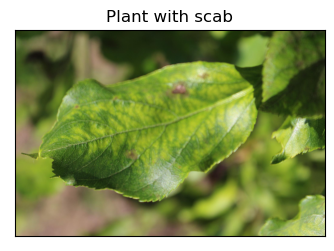

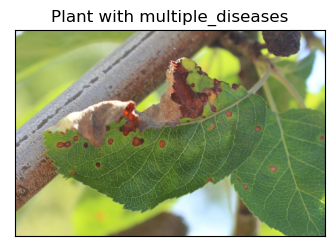

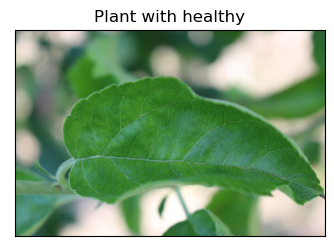

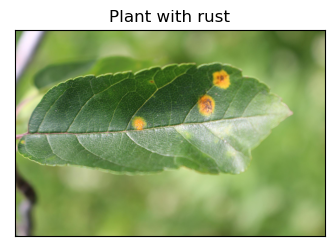

In [44]:
for i in range(4):
    show_image(train.iloc[i]['image_id'], i)

# Data Preprocessing

In [45]:
img = load_image(train.iloc[0]['image_id'])

# Histogram Equalization
def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to the Y channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])

    # Convert the image back to RGB format
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

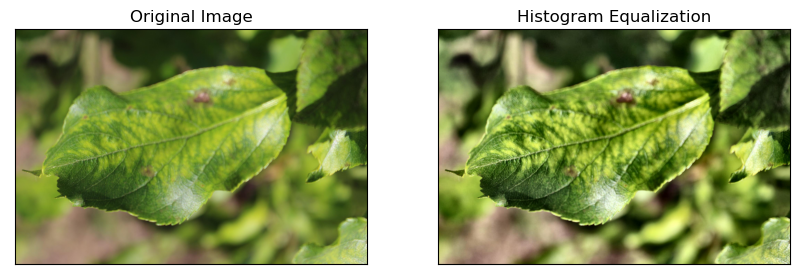

In [46]:
preprocessed_img = histogram_equalization(img)

# Show histogram equalization comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(preprocessed_img)
ax[1].set_title('Histogram Equalization')

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
plt.show()


In [47]:
def init_grabcut_mask(h, w):
    mask = np.ones((h, w), np.uint8) * cv2.GC_PR_BGD
    mask[h//4:3*h//4, w//4:3*w//4] = cv2.GC_PR_FGD
    mask[2*h//5:3*h//5, 2*w//5:3*w//5] = cv2.GC_FGD
    return mask



def add_contours(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # if len(contours) != 0:
    #     cv2.drawContours(image, contours, -1, (255, 0, 0), 3)
    #     c = max(contours, key = cv2.contourArea)
    #     x,y,w,h = cv2.boundingRect(c)
    #     cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0) ,2)
    


def remove_background(image):
    h, w = image.shape[:2]
    mask = init_grabcut_mask(h, w)
    bgm = np.zeros((1, 65), np.float64)
    fgm = np.zeros((1, 65), np.float64)
    cv2.grabCut(image, mask, None, bgm, fgm, 1, cv2.GC_INIT_WITH_MASK)
    mask_binary = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    result = cv2.bitwise_and(image, image, mask = mask_binary)
    add_contours(result, mask_binary) # optional, adds visualizations
    return result


def preprocess_image(image):
    image = histogram_equalization(image)
    image = remove_background(image)
    return image

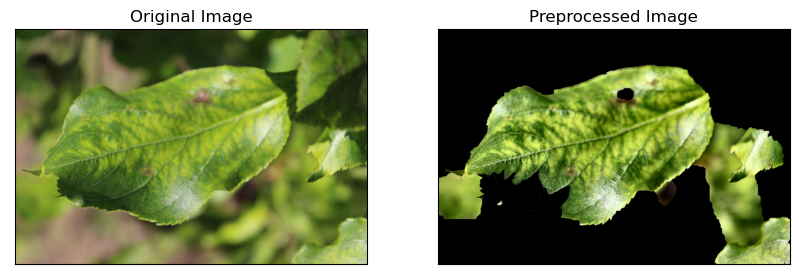

In [48]:
img = load_image(train.iloc[0]['image_id'])
# resize image
preprocessed_img = preprocess_image(img)

# Show preprocessing comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(preprocessed_img)
ax[1].set_title('Preprocessed Image')

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

plt.show()

In [58]:
import os

output_directory = './data/preprocessed_images/'
os.makedirs(output_directory + "train", exist_ok=True)
os.makedirs(output_directory + "test", exist_ok=True)

# Preprocess all images
def preprocess_images(df, category):
    for i in range(len(df)):
        image = load_image(df.iloc[i]['image_id'])
        # resize image
        image = cv2.resize(image, (682, 455))
        image = preprocess_image(image)

        # save image
        cv2.imwrite(f'{output_directory}{category}/{df.iloc[i]["image_id"]}.jpg', image)

preprocess_images(train, "train")
preprocess_images(test, "test")

1821

In [50]:
img = load_image(train.iloc[0]['image_id'])
img.shape

(1365, 2048, 3)

# Data Augmentation